In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## What is a chatbot?
## A chatbot is a software or computer program that simulates human conversation or "chatter" through text or voice interactions.
## Chatbot are used by almost every tech based company and become trending these days


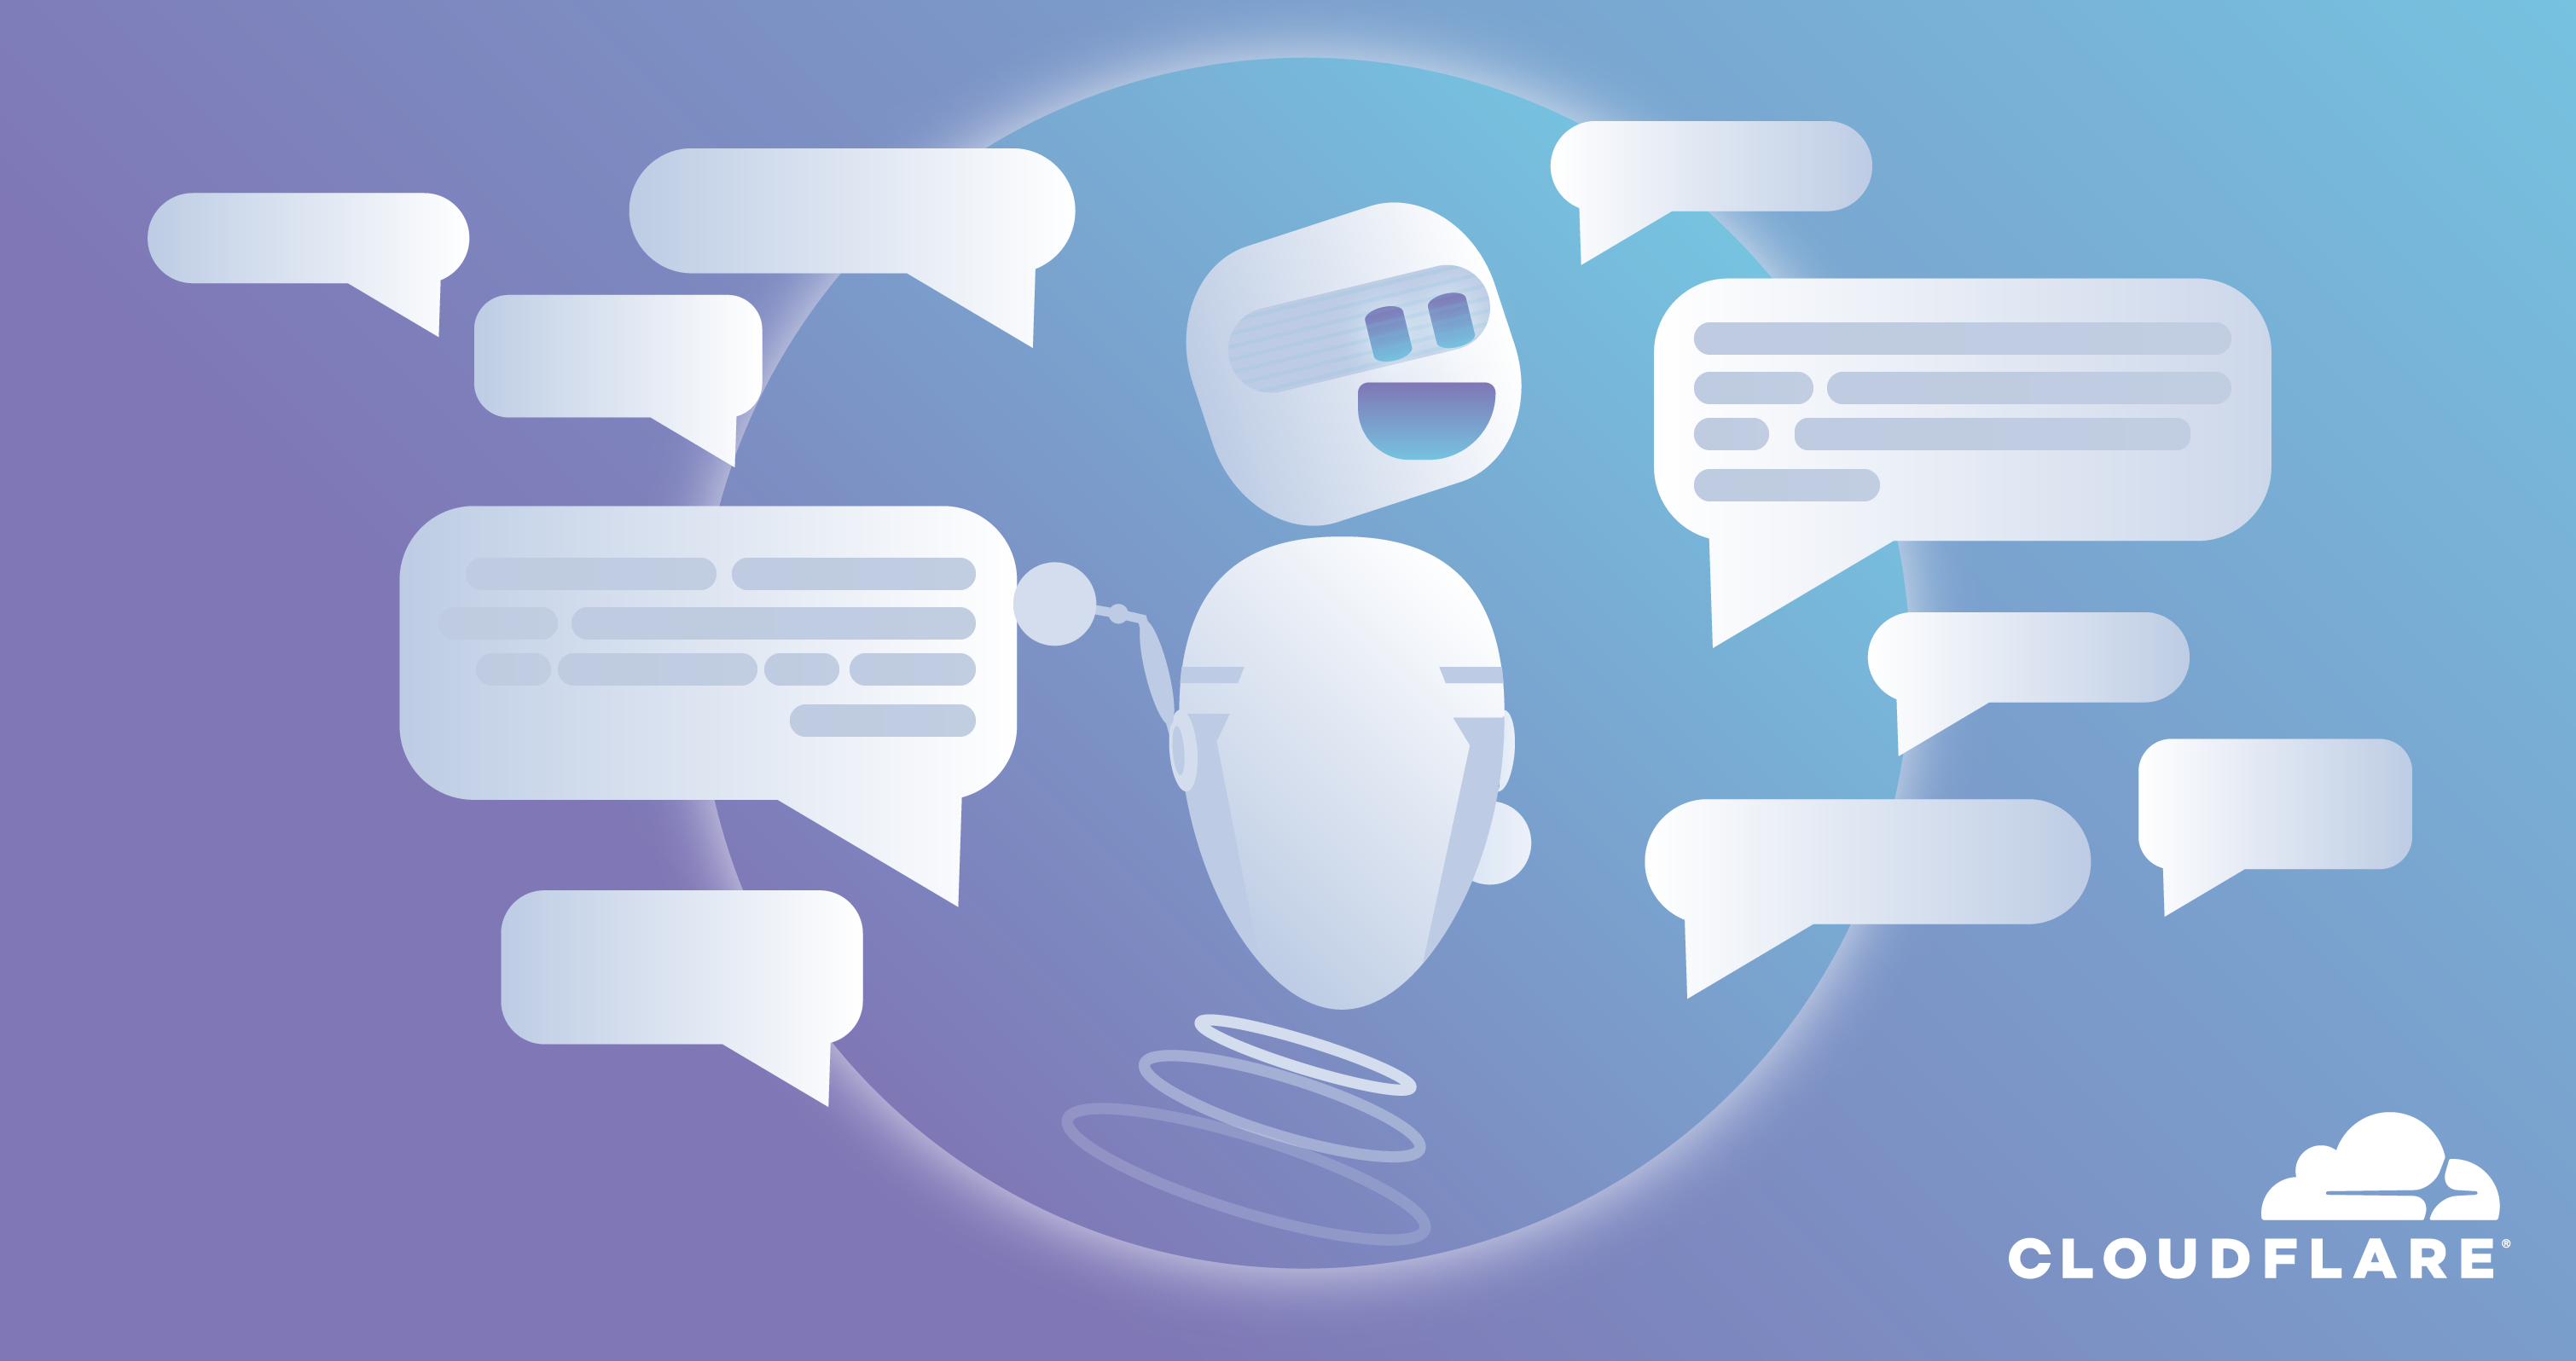

In [2]:

from IPython.display import Image
Image("../input/chatbot/chat.png")

## Importing Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd

print( tf.version)


2023-09-04 13:36:55.002390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 13:36:55.649422: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<module 'tensorflow._api.v2.version' from '/home/alex/projects/ml/ml_course/venv/lib/python3.10/site-packages/tensorflow/_api/v2/version/__init__.py'>


## Reading the data

In [4]:
data_path='../input/chatbot-training-dataset'

since data path is a directory to access it i  have used the following lines to extract it

In [5]:
import os
data_paths = [os.path.join(pth, f) 
for pth, dirs, files in os.walk(data_path) for f in files]
data_paths

['../input/chatbot-training-dataset/chatbot dataset.txt']

In [4]:
data_path1='kaggle/input/chatbot dataset.txt'

In [5]:
input_texts = []
target_texts = []
with open(data_path1) as f:
    lines = f.read().split('\n')
for line in lines[: min(600, len(lines) - 1)]:
    input_text = line.split('\t')[0]
    target_text = line.split('\t')[1]
    input_texts.append(input_text)
    target_texts.append(target_text)

In [6]:
print('type of input_text',type(input_text))
print('type of target_texts',type(target_texts))

type of input_text <class 'str'>
type of target_texts <class 'list'>


In [7]:
##converting the list in pandas dataframe since input_text,target_text are both are type of list
zippedList =  list(zip(input_texts, target_texts))
lines = pd.DataFrame(zippedList, columns = ['input' , 'output']) 
lines.head()

,input,output
0,What are your interests,I am interested in all kinds of things. We can...
1,What are your favorite subjects,"My favorite subjects include robotics, compute..."
2,What are your interests,"I am interested in a wide variety of topics, a..."
3,What is your number,I don't have any number
4,What is your number,23 skiddoo!


## since the chatbot is train over seq2seq model as the data is sequential
# for seq2seq encoder-decoder will best choice to train chatbot

## what is Encoder and decoder?

The encoder-decoder model is a way of using recurrent neural networks for sequence-to-sequence prediction problems.

It was initially developed for machine translation problems, although it has proven successful at related sequence-to-sequence prediction problems such as text summarization and question answering.

The approach involves two recurrent neural networks, one to encode the input sequence, called the encoder, and a second to decode the encoded input sequence into the target sequence called the decoder.

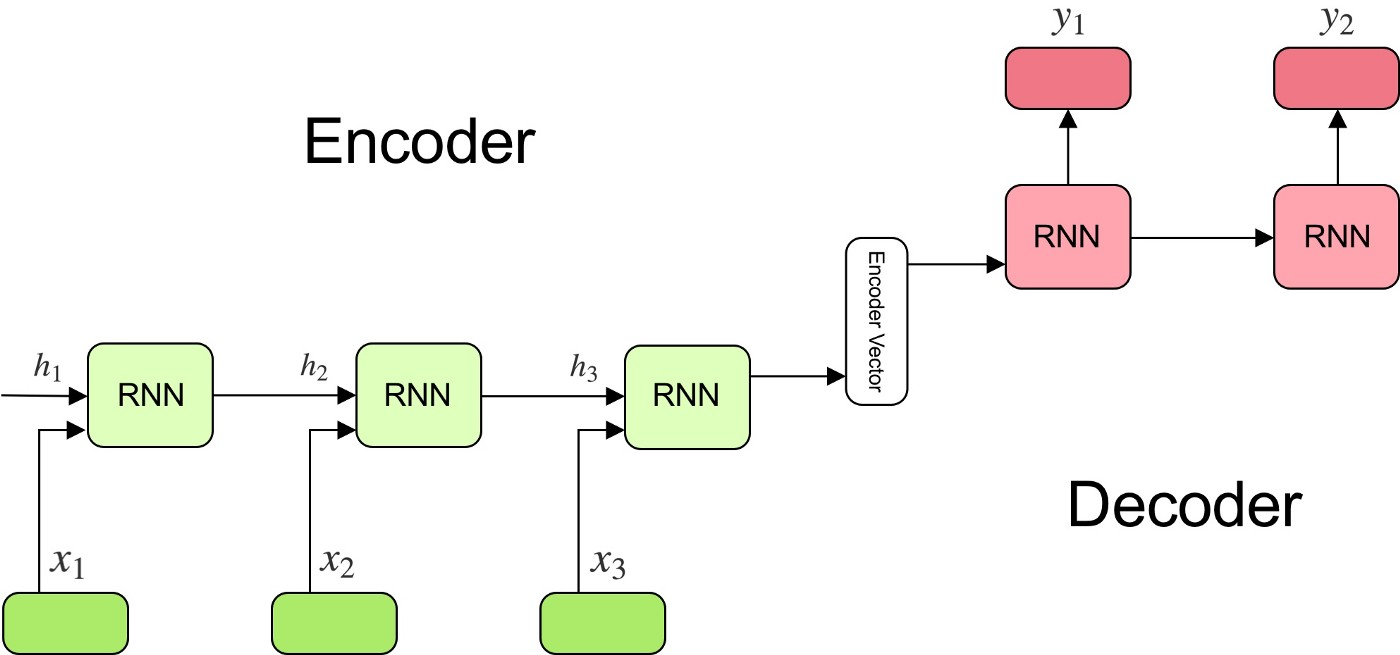

In [10]:
from IPython.display import Image
Image("../input/encoderdecoder/1_1JcHGUU7rFgtXC_mydUA_Q.jpeg")

## Preparing input data for the Encoder

In [8]:
input_lines = list()
for line in lines.input:
    input_lines.append( line ) 

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( input_lines ) 
tokenized_input_lines = tokenizer.texts_to_sequences( input_lines ) 

length_list = list()
for token_seq in tokenized_input_lines:
    length_list.append( len( token_seq ))
max_input_length = np.array( length_list ).max()
print( 'Input max length is {}'.format( max_input_length ))

padded_input_lines = preprocessing.sequence.pad_sequences( tokenized_input_lines , maxlen=max_input_length , padding='post' )
encoder_input_data = np.array( padded_input_lines )
print( 'Encoder input data shape -> {}'.format( encoder_input_data.shape ))

input_word_dict = tokenizer.word_index
num_input_tokens = len( input_word_dict )+1
print( 'Number of Input tokens = {}'.format( num_input_tokens))

Input max length is 22
Encoder input data shape -> (566, 22)
Number of Input tokens = 518


In [9]:
encoder_input_data

array([[  4,   3,  12, ...,   0,   0,   0],
       [  4,   3,  12, ...,   0,   0,   0],
       [  4,   3,  12, ...,   0,   0,   0],
       ...,
       [498, 499,   9, ...,   0,   0,   0],
       [  9, 207, 208, ...,   0,   0,   0],
       [510, 192,   5, ...,   0,   0,   0]], dtype=int32)

## Preparing input data for the Decoder


In [10]:
output_lines = list()
for line in lines.output:
    output_lines.append( '<START> ' + line + ' <END>' )  

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( output_lines ) 
tokenized_output_lines = tokenizer.texts_to_sequences( output_lines ) 

length_list = list()
for token_seq in tokenized_output_lines:
    length_list.append( len( token_seq ))
max_output_length = np.array( length_list ).max()
print( 'Output max length is {}'.format( max_output_length ))

padded_output_lines = preprocessing.sequence.pad_sequences( tokenized_output_lines , maxlen=max_output_length, padding='post' )
decoder_input_data = np.array( padded_output_lines )
print( 'Decoder input data shape -> {}'.format( decoder_input_data.shape ))

output_word_dict = tokenizer.word_index
num_output_tokens = len( output_word_dict )+1
print( 'Number of Output tokens = {}'.format( num_output_tokens))


Output max length is 74
Decoder input data shape -> (566, 74)
Number of Output tokens = 1692


## Preparing target data for the Decoder 

In [11]:
decoder_target_data = list()
for token_seq in tokenized_output_lines:
    decoder_target_data.append( token_seq[ 1 : ] ) 
    
padded_output_lines = preprocessing.sequence.pad_sequences( decoder_target_data , maxlen=max_output_length, padding='post' )
onehot_output_lines = utils.to_categorical( padded_output_lines , num_output_tokens )
decoder_target_data = np.array(onehot_output_lines )
print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape ))

Decoder target data shape -> (566, 74, 1692)


## Defining the Model


In [12]:
encoder_inputs = tf.keras.layers.Input(shape=( None , ))
encoder_embedding = tf.keras.layers.Embedding( num_input_tokens, 256 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 256 , return_state=True , recurrent_dropout=0.2 , dropout=0.2 )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( None ,  ))
decoder_embedding = tf.keras.layers.Embedding( num_output_tokens, 256 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( num_output_tokens , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')

model.summary()

2023-09-04 13:38:22.100065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-04 13:38:22.160841: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 256)            132608    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            433152    ['input_2[0][0]']             
                                                                                              

## Training

In [13]:
model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=124, epochs=500) 
model.save( 'model.h5' ) 

Epoch 1/500
5/5 [==============================] - 6s 419ms/step - loss: 7.4261
Epoch 2/500
5/5 [==============================] - 2s 417ms/step - loss: 7.3151
Epoch 3/500
5/5 [==============================] - 2s 416ms/step - loss: 6.6028
Epoch 4/500
5/5 [==============================] - 2s 414ms/step - loss: 5.9513
Epoch 5/500
5/5 [==============================] - 2s 414ms/step - loss: 5.8361
Epoch 6/500
5/5 [==============================] - 2s 413ms/step - loss: 5.7356
Epoch 7/500
5/5 [==============================] - 2s 440ms/step - loss: 5.7047
Epoch 8/500
5/5 [==============================] - 2s 411ms/step - loss: 5.6660
Epoch 9/500
5/5 [==============================] - 2s 408ms/step - loss: 5.6367
Epoch 10/500
5/5 [==============================] - 2s 409ms/step - loss: 5.5987
Epoch 11/500
5/5 [==============================] - 2s 409ms/step - loss: 5.5569
Epoch 12/500
5/5 [==============================] - 2s 406ms/step - loss: 5.5125
Epoch 13/500
5/5 [===================

/home/alex/projects/ml/ml_course/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Inference models

In [14]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=(256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=(256,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [15]:
import tensorflow as tf
def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append( input_word_dict[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')

In [21]:
enc_model , dec_model = make_inference_models()
for epoch in range( encoder_input_data.shape[0] ):
    states_values = enc_model.predict( str_to_tokens( input( 'User: ' ) ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = output_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in output_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print( "Bot:" +decoded_translation.replace(' end', '') )
    print()

1/1 [==============================] - 0s 16ms/step
Bot: hello

1/1 [==============================] - 0s 16ms/step
Bot: i am just an artificial intelligence

1/1 [==============================] - 0s 13ms/step
Bot: ai is the field of science which concerns itself with building hardware and software that replicates the functions of the human mind

1/1 [==============================] - 0s 13ms/step
Bot: i find i'm quite fond of the number 42

1/1 [==============================] - 0s 19ms/step
Bot: i consume ram and binary digits

1/1 [==============================] - 0s 13ms/step
Bot: i'm a software program i blame the hardware



KeyError: 'bye'

## Thanks for visiting this notebook, Happy Kaggling!!!!!!!!!!!!!